# Numerical simulation of 1D Reaction-Diffusion PDE
Here we numerically integrate PDE of $A = A(z,t)$ subject to diffusion and a reaction $f = -dV/dA$.
$$\partial_t A = D \partial_{z}^2 A + f(A)$$

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sympy as sp
import time

In [2]:
def _extend_periodic(v):
    """Add ghost cells for periodic BC: [v_{-1}, v, v_{N}] with v_{-1}=v[-1], v_{N}=v[0]."""
    return np.concatenate(([v[-1]], v, [v[0]]))
    
def _rhs(A,func, D, dx):
    """
    Deterministic RHS for reaction-diffusion system, with reaction them fun and diffusion coeficent D
    Returns dAdt, dudt arrays of length len(A).
    """
    A_e = _extend_periodic(A);
    
    # centered diffusion (Laplacian), reactions
    diffusion_A =   (D/(dx**2))*(A_e[2:] - 2.0*A_e[1:-1] + A_e[0:-2]);
    reaction_A  =   func(A_e[1:-1]);

    dAdt = diffusion_A + reaction_A
    
    return dAdt

def Stepper_Reaction_Diffusion_Euler(A, func, D, dx, dt):
    """
    One Forward Euler step for reaction diffusion system=,
    """
    dAdt   = _rhs(A,func, D, dx)
    A_next = A + dt*dAdt
    
    return A_next

def Stepper_Reaction_Diffusion_RK4(A, func, D, dx, dt):
    """
    One RK4 step for reaction diffusion system=,
    """
    k1 = _rhs(A, func, D, dx)
    k2 = _rhs(A + 0.5*dt*k1, func, D, dx)
    k3 = _rhs(A + 0.5*dt*k2, func, D, dx)
    k4 = _rhs(A + dt*k3, func, D, dx)

    # RK4 combine 
    A_next = A + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    return A_next

In [7]:
# Simulation

# Parameters
D       = 0.1 #diffusion coeficent
a_val   =  1  #reaction parameter a 
eps_val = 0.2 #reaction parameter epsilon  
params = {'a': a_val, 'eps': eps_val, 'D': D}

#simulation parameters
dx = 0.1    # spatial reolution
dt = 0.001  # time step
T = 100     # total time
L = 30      # system length
sampling_time = 1 #times between samplings

M = int(L/dx);  # number of lattice points 
N = int(T/dt);  # number of steps
n_samp =  max(int(sampling_time/dt),1);

#Defeniton of the evolution function
f = lambda x: -4*(a_val**2)*x*(x**2 - 1) - eps_val;

# Arrays to store results
A_state = np.zeros(M, dtype = np.float64)             #The system state 
Sim_Data = np.zeros(shape=(1,M), dtype = np.float64) #saved sim data
#inital conditions
z  = np.linspace(0, L, M)
A0 = 1-2*np.exp(-5*(z - L/2)**2)

#initate state and data matrix
A_state  = A0;
Sim_Data[0] = A0;

#forward integration 
print(f'Simulation started, parameters = {params}')
wall_time_start = time.time()
for i in range(N-1):
    A_state= Stepper_Reaction_Diffusion_RK4(A_state, f, D, dx, dt) 
    if i%n_samp == 0: #save data every n_samp timesteps
        Sim_Data = np.vstack([Sim_Data, A_state])
    if i%((N)//10) == 0:  #Plot ptogress every 10%
        print(f'Progress {(i/N)*100}%')
wall_time = time.time() - wall_time_start
print(f'Simulation done. Wall_Time = {wall_time:.2f}[sec]')  

Simulation started, parameters = {'a': 1, 'eps': 0.2, 'D': 0.1}
Progress 0.0%
Progress 10.0%
Progress 20.0%
Progress 30.0%
Progress 40.0%
Progress 50.0%
Progress 60.0%
Progress 70.0%
Progress 80.0%
Progress 90.0%
Simulation done. Wall_Time = 5.43[sec]


Text(0.5, 1.0, 'Fronts - 1D')

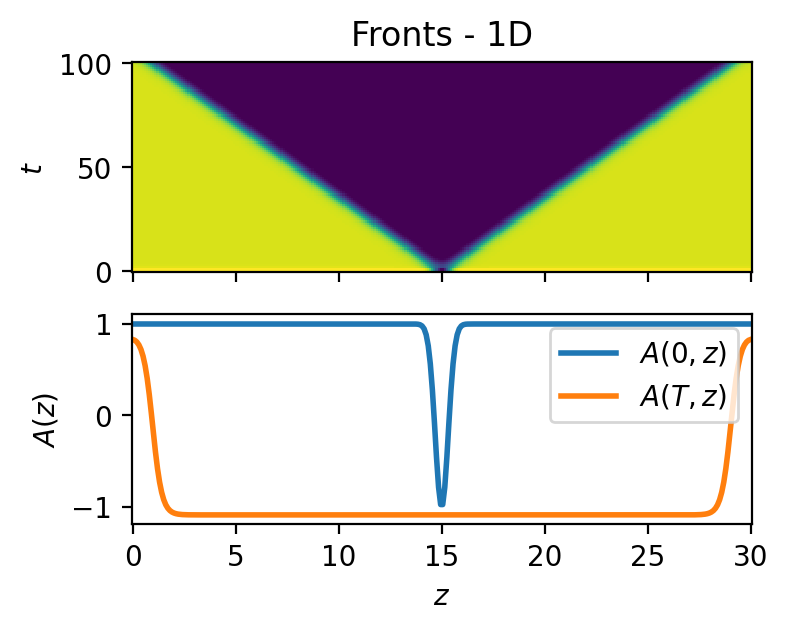

In [8]:
## plot results
#create coordinate vecotrs
z_co  = np.linspace(0, L, M)
t_co  = np.linspace(0, T, Sim_Data.shape[0])

#make mesh grid
t_m,x_m = np.meshgrid(t_co,z_co) 

fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(4,3), dpi=200, sharex = True)
ax[0].pcolormesh(x_m,t_m,Sim_Data.T,shading='nearest',vmin = -1, vmax = 1)
ax[1].plot(z_co, Sim_Data[0],  linewidth = 2, label = '$A(0,z)$')
ax[1].plot(z_co, Sim_Data[-1], linewidth = 2, label = '$A(T,z)$')

ax[0].set_ylabel('$t$')
ax[1].set_ylabel('$A(z)$')
ax[1].set_xlabel('$z$')
ax[1].legend()
ax[0].set_title('Fronts - 1D')    

Text(0.5, 1.0, 'Fronts - 1D')

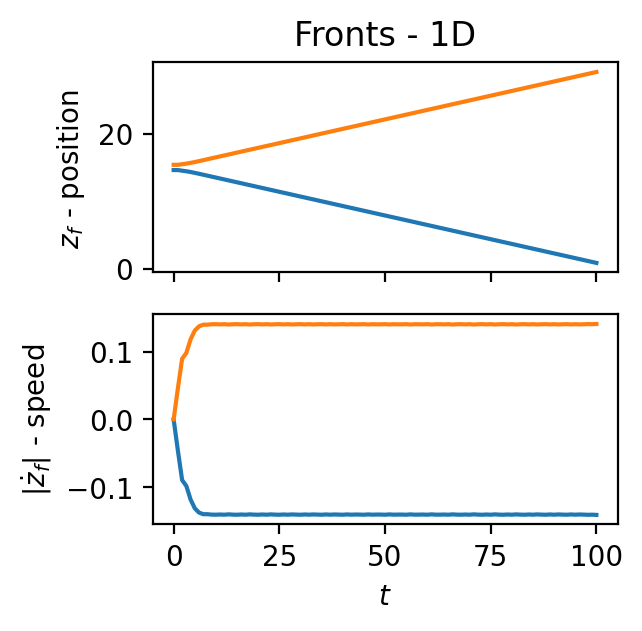

In [9]:
from front_tracking import get_front_trajectories #custome code to extract font trajectories
#find front trajectories
front_value = 0.05; #value of A defining a front
d_max  = 0.5;  #maximum distance fo connected components
traj_list = get_front_trajectories(Sim_Data, z_co, front_value, d_max,sampling_time)


#Plot results
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(3,3), dpi=200, sharex = True)

for traj in traj_list:
    ax[0].plot(traj.t,traj.x)
    front_speed = (np.gradient(traj.x, traj.t))
    ax[1].plot(traj.t,front_speed)
    
ax[0].set_ylabel('$z_f$ - position ')
ax[1].set_ylabel('$|\\dot{z}_f|$ - speed')
ax[1].set_xlabel('$t$')
ax[0].set_title('Fronts - 1D')    